In [1]:
# Import Libraries
import pandas as pd   
import numpy as np            
import seaborn as sns                 
import matplotlib.pyplot as plt                

In [2]:
data = pd.read_csv("mydrone_Data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8127 entries, 0 to 8126
Data columns (total 52 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time(millisecond)                            8127 non-null   int64  
 1   datetime(utc)                                8127 non-null   object 
 2   latitude                                     8127 non-null   float64
 3   longitude                                    8127 non-null   float64
 4   height_above_takeoff(feet)                   8127 non-null   float64
 5   height_above_ground_at_drone_location(feet)  8127 non-null   float64
 6   ground_elevation_at_drone_location(feet)     8127 non-null   float64
 7   altitude_above_seaLevel(feet)                8127 non-null   float64
 8   height_sonar(feet)                           8127 non-null   int64  
 9   speed(mph)                                   8127 non-null   float64
 10  

In [3]:
def clean_cols(input_df):
    input_df.columns = input_df.columns.str.strip().str.lower().str.replace(" ","_")
    return input_df

In [4]:
data_trans = clean_cols(data)

In [5]:
data_num = data_trans.select_dtypes(["float64", "int64"])
data_num.head(2)

,time(millisecond),latitude,longitude,height_above_takeoff(feet),height_above_ground_at_drone_location(feet),ground_elevation_at_drone_location(feet),altitude_above_sealevel(feet),height_sonar(feet),speed(mph),distance(feet),...,voltagecell2,voltagecell3,voltagecell4,voltagecell5,voltagecell6,current(a),battery_temperature(f),altitude(feet),ascent(feet),flycstateraw
0,5510,36.559037,-89.074368,29.855644,29.855644,367.743461,397.599105,0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,15.88,29.950016,397.599105,29.855644,14
1,5610,36.559037,-89.074368,30.839896,30.839896,367.743461,398.583357,0,0.0,0.047036,...,NaN,NaN,NaN,NaN,NaN,15.88,29.950016,398.583357,30.839896,14


In [6]:
# data_num.where()

In [7]:
mask_cols = data_num.columns[data_num.columns.str.startswith("voltage")].tolist()
mask_cols

['voltage(v)',
 'voltagecell1',
 'voltagecell2',
 'voltagecell3',
 'voltagecell4',
 'voltagecell5',
 'voltagecell6']

In [8]:
# mask_cols = data_num.columns.str.startswith("voltage")
data_cleaned = data_num.drop(columns=mask_cols)

In [9]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8127 entries, 0 to 8126
Data columns (total 42 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time(millisecond)                            8127 non-null   int64  
 1   latitude                                     8127 non-null   float64
 2   longitude                                    8127 non-null   float64
 3   height_above_takeoff(feet)                   8127 non-null   float64
 4   height_above_ground_at_drone_location(feet)  8127 non-null   float64
 5   ground_elevation_at_drone_location(feet)     8127 non-null   float64
 6   altitude_above_sealevel(feet)                8127 non-null   float64
 7   height_sonar(feet)                           8127 non-null   int64  
 8   speed(mph)                                   8127 non-null   float64
 9   distance(feet)                               8127 non-null   float64
 10  

# Build Model for prediction drone battery temperature 

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


In [11]:
bat_cols = data_cleaned.columns[data_cleaned.columns.str.startswith("bat")]

X = data_cleaned.drop(columns=['battery_temperature(f)'])
y = data_cleaned['battery_temperature(f)']

print(X.shape)
print(y.shape)
print([x for x in bat_cols])

(8127, 41)
(8127,)
['battery_percent', 'battery_temperature(f)']


In [29]:
class SplitTransform:
    def __init__ (self, X, y, random_state=42, test_size=0.2, scaler=StandardScaler()):
        self.X=X
        self.y=y
        self.random_state=random_state
        self.test_size=test_size
        self.scaler=scaler
        
    def splitdata(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X,
                                                    self.y,
                                                    test_size= self.test_size,
                                                    random_state=self.random_state)
        return self
        
    def scaledata(self):
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)
        return self
    
    def result(self):
        return self.X_train, self.X_test, self.y_train, self.y_test
      

In [30]:
X_train, X_test, y_train, y_test = (
    SplitTransform(X, y)
    .splitdata()
    .scaledata()
    .result()
)

In [31]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6501, 41)
X_test shape: (1626, 41)
y_train shape : (6501,)
y_test shape: (1626,)


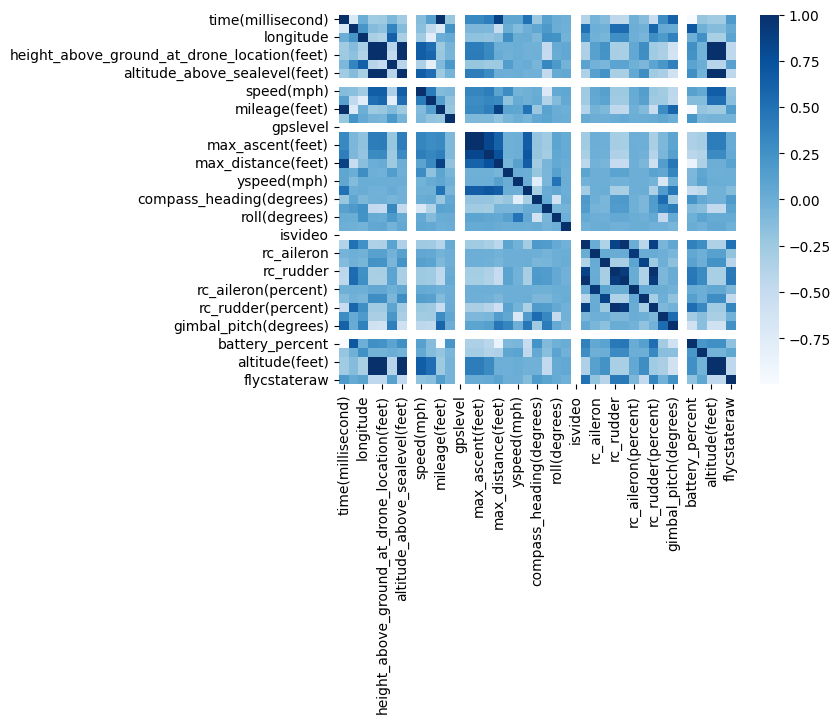

In [32]:
df_corr = X.corr()
sns.heatmap(data=df_corr, 
            fmt=".1f",
            annot=False,
            cmap="Blues")
plt.show()

In [33]:
# Apply Model
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, StratifiedKFold

In [34]:
estimator = XGBRegressor(n_estimators=100)

param_grid = {"learning_rate" : [0.02, 0.5, 0.7],
              "max_depth":[3, 6, 10],
              "min_child_weight":[2, 5, 10],
              "subsample":[0.6, 0.8, 1.0]
              }

grid_search = GridSearchCV(estimator=estimator,
                           param_grid = param_grid,
                           verbose=1,
                           cv=5,
                           )

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'learning_rate': [0.02, 0.5, ...], 'max_depth': [3, 6, ...], 'min_child_weight': [2, 5, ...], 'subsample': [0.6, 0.8, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and para

In [35]:
grid_search.best_estimator_

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [38]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = grid_search.predict(X_test)
# print(y_pred.reshape(-1,1))
# print(y_test.shape)

print("R²:", r2_score(y_test, y_pred.ravel()))
print("RMSE:", mean_squared_error(y_test, y_pred))

R²: 0.999912011677111
RMSE: 0.0033578454510192163


C:\Users\Owner\AppData\Local\Temp\ipykernel_2304\4003442580.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


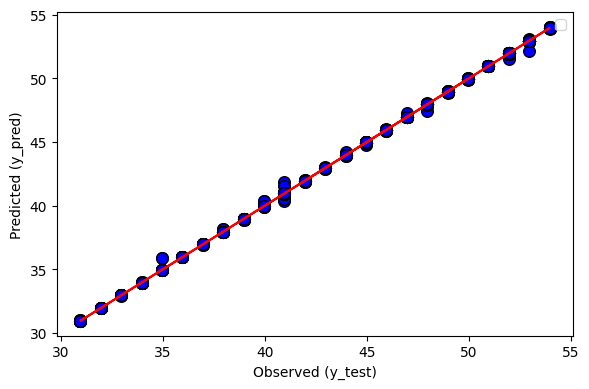

In [46]:
# Plot

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=1,s=70,  edgecolor="k", color="blue")
plt.plot(y_test, y_test, color="red")

plt.xlabel("Observed (y_test)")
plt.ylabel("Predicted (y_pred)")
plt.legend()
plt.tight_layout()
plt.show()


# Save the Model

In [40]:
import joblib

joblib.dump(grid_search, "xgboost_model.pkl")

['xgboost_model.pkl']